In [4]:
# List datasets mounted under /kaggle/input
!ls /kaggle/input/


fracture-multi-region-x-ray-data


In [5]:
import os, zipfile

# Path where Kaggle mounted your dataset
dataset_path = "/kaggle/input/fracture-multi-region-x-ray-data/fracture-multi-region-x-ray-data.zip"
extract_to   = "/kaggle/working/data"

# If it's a zip file, extract it
if os.path.exists(dataset_path):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(" Dataset extracted to:", extract_to)
    base_path = os.path.join(extract_to, "Bone_Fracture_Binary_Classification", "Bone_Fracture_Binary_Classification")
else:
    # If already unzipped, just point to it directly
    base_path = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification"

print("Base path set to:", base_path)


Base path set to: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification


In [3]:

# Walk through all folders and subfolders
for root, dirs, files in os.walk(base_path):
    print("📁", root)
    for d in dirs:
        print("   └──", d)


📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification
   └── val
   └── test
   └── train
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val
   └── not fractured
   └── fractured
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test
   └── not fractured
   └── fractured
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured
📁 /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Bin

In [6]:
# Define dataset splits
train_dir = os.path.join(base_path, "train")
val_dir   = os.path.join(base_path, "val")
test_dir  = os.path.join(base_path, "test")

# Quick check
print("Train:", train_dir)
print("Val:", val_dir)
print("Test:", test_dir)


Train: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train
Val: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val
Test: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test


In [7]:
def count_images(path):
    fractured = len(os.listdir(os.path.join(path, "fractured")))
    not_fractured = len(os.listdir(os.path.join(path, "not fractured")))
    return fractured, not_fractured

train_f, train_nf = count_images(train_dir)
val_f, val_nf     = count_images(val_dir)
test_f, test_nf   = count_images(test_dir)

print("TRAIN:", train_f, "fractured |", train_nf, "not fractured")
print("VAL  :", val_f, "fractured |", val_nf, "not fractured")
print("TEST :", test_f, "fractured |", test_nf, "not fractured")


TRAIN: 4606 fractured | 4640 not fractured
VAL  : 337 fractured | 492 not fractured
TEST : 238 fractured | 268 not fractured


In [7]:
from PIL import Image

def remove_corrupt_images(directory):
    removed = 0
    for root, _, files in os.walk(directory):
        for fname in files:
            file_path = os.path.join(root, fname)
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1
    return removed

total_removed = 0
for path in [train_dir, val_dir, test_dir]:
    total_removed += remove_corrupt_images(path)

print(" Removed corrupted images:", total_removed)


 Removed corrupted images: 0


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Train generator with augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation & Test: only rescale
val_gen  = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='binary')
val_data   = val_gen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='binary')
test_data  = test_gen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=False)

print("Class indices (folder → label index):")
print(train_data.class_indices)


Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Class indices (folder → label index):
{'fractured': 0, 'not fractured': 1}


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Fine-tune last 10 layers (ResNet50 has ~175 layers)
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 4,728,065 (18.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "/kaggle/working/resnet50_model_best.h5"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)


In [11]:
history_resnet = resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[checkpoint, early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1758219089.126563      99 service.cc:148] XLA service 0x7e7004001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758219089.127251      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758219090.812054      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/289 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.5312 - loss: 0.7314   

I0000 00:00:1758219096.626367      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6218 - loss: 0.6494

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.62847, saving model to /kaggle/working/resnet50_model_best.h5
289/289 ━━━━━━━━━━━━━━━━━━━━ 202s 633ms/step - accuracy: 0.6219 - loss: 0.6493 - val_accuracy: 0.6285 - val_loss: 0.8873
Epoch 2/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6965 - loss: 0.5662
Epoch 2: val_accuracy improved from 0.62847 to 0.64053, saving model to /kaggle/working/resnet50_model_best.h5
289/289 ━━━━━━━━━━━━━━━━━━━━ 123s 424ms/step - accuracy: 0.6966 - loss: 0.5662 - val_accuracy: 0.6405 - val_loss: 1.2303
Epoch 3/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.7271 - loss: 0.5442
Epoch 3: val_accuracy improved from 0.64053 to 0.71170, saving model to /kaggle/working/resnet50_model_best.h5
289/289 ━━━━━━━━━━━━━━━━━━━━ 124s 428ms/step - accuracy: 0.7271 - loss: 0.5441 - val_accuracy: 0.7117 - val_loss: 0.5183
Epoch 4/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7449 - loss: 0.5063
Epoch 4: val_accuracy improved from 0.7117

In [12]:
# Save final model
resnet_model.save("/kaggle/working/resnet50_model_final.h5")
print(" Model saved as resnet50_model_final.h5")

# Load best model
from tensorflow.keras.models import load_model
resnet_model = load_model("/kaggle/working/resnet50_model_final.h5")
print(" Loaded ResNet50 model from saved .h5")


 Model saved as resnet50_model_final.h5
 Loaded ResNet50 model from saved .h5


In [15]:
from IPython.display import FileLink

# Download only the best model
FileLink("resnet50_model_best.h5")

/kaggle/working/resnet50_model_best.h5

In [13]:
train_loss, train_acc = resnet_model.evaluate(train_data, verbose=0)
val_loss, val_acc     = resnet_model.evaluate(val_data, verbose=0)
test_loss, test_acc   = resnet_model.evaluate(test_data, verbose=0)

print(" Model: ResNet50")
print(f" Training Accuracy:   {train_acc*100:.2f}% | Loss: {train_loss:.4f}")
print(f" Validation Accuracy: {val_acc*100:.2f}% | Loss: {val_loss:.4f}")
print(f" Test Accuracy:       {test_acc*100:.2f}% | Loss: {test_loss:.4f}")


 Model: ResNet50
 Training Accuracy:   73.73% | Loss: 0.5030
 Validation Accuracy: 83.11% | Loss: 0.3943
 Test Accuracy:       78.26% | Loss: 0.4792


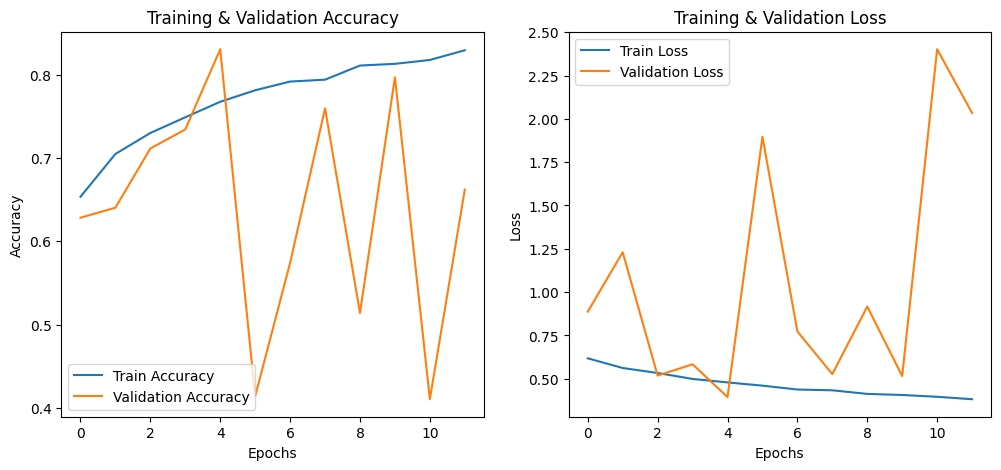

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step
Classification Report:
               precision    recall  f1-score   support

    Fractured       0.72      0.88      0.79       238
Not Fractured       0.87      0.70      0.77       268

     accuracy                           0.78       506
    macro avg       0.79      0.79      0.78       506
 weighted avg       0.80      0.78      0.78       506



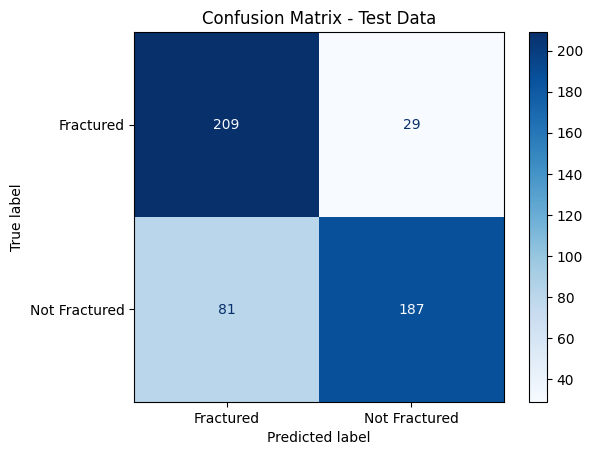

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_pred_probs = resnet_model.predict(test_data)
y_pred_classes = (y_pred_probs > 0.5).astype("int32").flatten()

print("Classification Report:")
print(classification_report(
    test_data.classes,
    y_pred_classes,
    target_names=["Fractured", "Not Fractured"]
))

cm = confusion_matrix(test_data.classes, y_pred_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=["Fractured", "Not Fractured"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Data")
plt.show()


EfficientNet-B0

In [18]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pretrained EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Fine-tune last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

efficientnet_model = Model(inputs=base_model.input, outputs=output)

efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

efficientnet_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 1,515,057 (5.78 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "/kaggle/working/efficientnetb0_model_best.h5"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)


In [20]:
history_effnet = efficientnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[checkpoint, early_stop],
    verbose=1
)


Epoch 1/25


E0000 00:00:1758221605.368444      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758221605.574556      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 34/289 ━━━━━━━━━━━━━━━━━━━━ 1:47 423ms/step - accuracy: 0.4994 - loss: 0.7097

E0000 00:00:1758221632.095913      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758221632.302982      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5031 - loss: 0.7051

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.59469, saving model to /kaggle/working/efficientnetb0_model_best.h5
289/289 ━━━━━━━━━━━━━━━━━━━━ 186s 533ms/step - accuracy: 0.5031 - loss: 0.7051 - val_accuracy: 0.5947 - val_loss: 0.6879
Epoch 2/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.5076 - loss: 0.6973
Epoch 2: val_accuracy improved from 0.59469 to 0.60434, saving model to /kaggle/working/efficientnetb0_model_best.h5
289/289 ━━━━━━━━━━━━━━━━━━━━ 123s 424ms/step - accuracy: 0.5076 - loss: 0.6973 - val_accuracy: 0.6043 - val_loss: 0.6905
Epoch 3/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.5031 - loss: 0.6970
Epoch 3: val_accuracy did not improve from 0.60434
289/289 ━━━━━━━━━━━━━━━━━━━━ 121s 419ms/step - accuracy: 0.5031 - loss: 0.6970 - val_accuracy: 0.6031 - val_loss: 0.6911
Epoch 4/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.4974 - loss: 0.6960
Epoch 4: val_accuracy did not improve from 0.60434
289/289 ━━━━━━━━━━━━━━━━━━━━ 120s 414ms

In [21]:
# Save final model
efficientnet_model.save("/kaggle/working/efficientnetb0_model_final.h5")
print(" Model saved as efficientnetb0_model_final.h5")

# Load best model
from tensorflow.keras.models import load_model
efficientnet_model = load_model("/kaggle/working/efficientnetb0_model_final.h5")
print(" Loaded EfficientNet-B0 model from saved .h5")


 Model saved as efficientnetb0_model_final.h5
 Loaded EfficientNet-B0 model from saved .h5


In [23]:
from IPython.display import FileLink

# Download only the best model
FileLink("efficientnetb0_model_final.h5")


/kaggle/working/efficientnetb0_model_final.h5

In [22]:
train_loss, train_acc = efficientnet_model.evaluate(train_data, verbose=0)
val_loss, val_acc     = efficientnet_model.evaluate(val_data, verbose=0)
test_loss, test_acc   = efficientnet_model.evaluate(test_data, verbose=0)

print(" Model: EfficientNet-B0")
print(f" Training Accuracy:   {train_acc*100:.2f}% | Loss: {train_loss:.4f}")
print(f" Validation Accuracy: {val_acc*100:.2f}% | Loss: {val_loss:.4f}")
print(f" Test Accuracy:       {test_acc*100:.2f}% | Loss: {test_loss:.4f}")


 Model: EfficientNet-B0
 Training Accuracy:   50.18% | Loss: 0.6935
 Validation Accuracy: 59.35% | Loss: 0.6851
 Test Accuracy:       52.96% | Loss: 0.6914


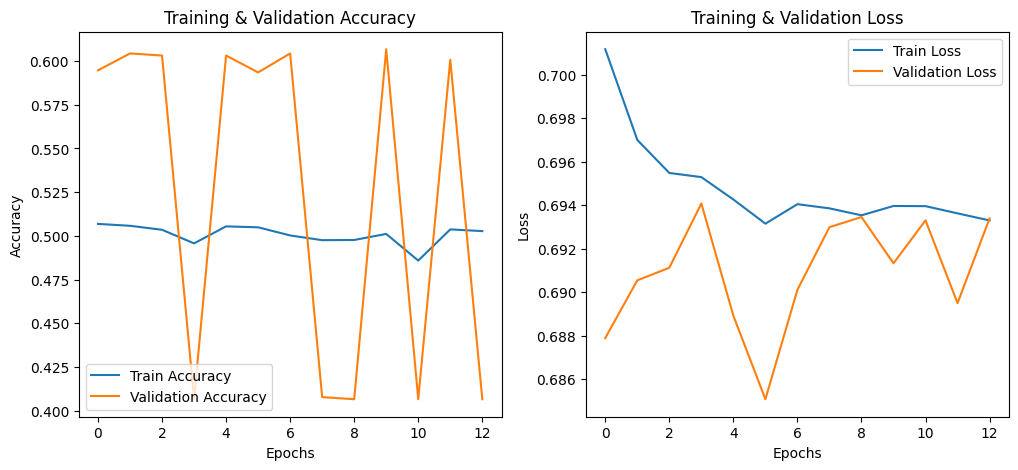

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_effnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_effnet.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_effnet.history['loss'], label='Train Loss')
plt.plot(history_effnet.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 583ms/step
Classification Report:
               precision    recall  f1-score   support

    Fractured       0.00      0.00      0.00       238
Not Fractured       0.53      1.00      0.69       268

     accuracy                           0.53       506
    macro avg       0.26      0.50      0.35       506
 weighted avg       0.28      0.53      0.37       506



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


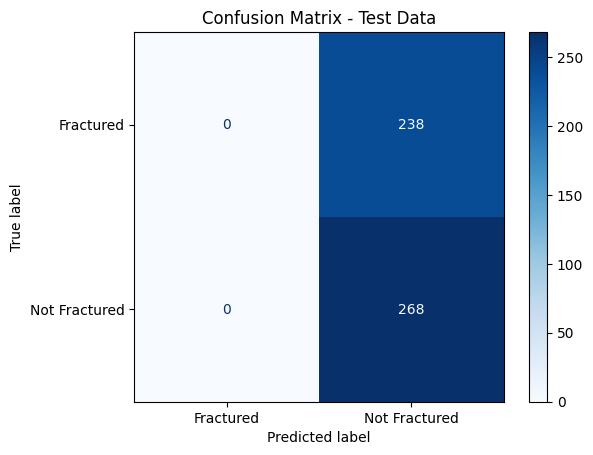

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred_probs = efficientnet_model.predict(test_data)
y_pred_classes = (y_pred_probs > 0.5).astype("int32").flatten()

print("Classification Report:")
print(classification_report(
    test_data.classes,
    y_pred_classes,
    target_names=["Fractured", "Not Fractured"]
))

cm = confusion_matrix(test_data.classes, y_pred_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=["Fractured", "Not Fractured"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Data")
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step


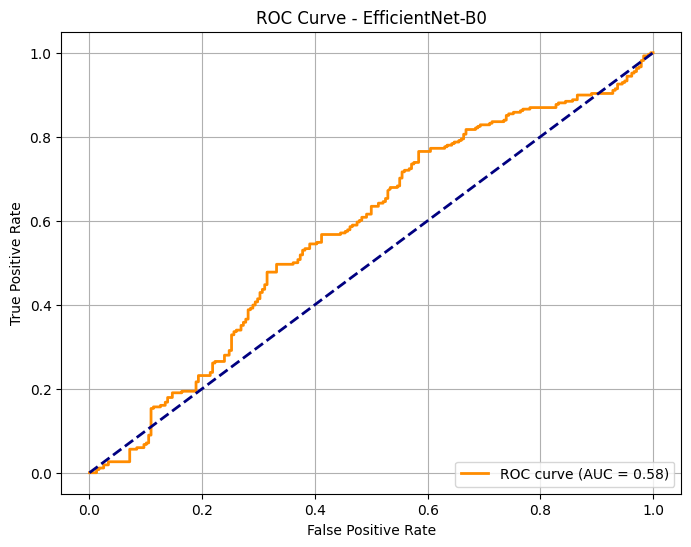

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test = test_data.classes
y_pred_prob = efficientnet_model.predict(test_data).ravel()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - EfficientNet-B0')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
